In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [5]:

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8116039037704468, 0.18839608132839203, 0.0, 0.0]
[0.0, 0.0, 0.0, 4.470348358154297e-06, 0.9999955296516418, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.8840827941894531, 0.0, 0.0, 0.11591717600822449, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.09531359374523163, 0.9046863913536072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0003416746330913156, 0.0, 0.0, 0.0, 0.0, 0.9996583461761475]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8952344655990601, 0.10476553440093994, 0.0]
[0.0, 0.0, 0.0, 0.9209010601043701, 0.0, 0.07909893989562988, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.00011098384857177734, 0.0, 0.0, 0.9998890161514282, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


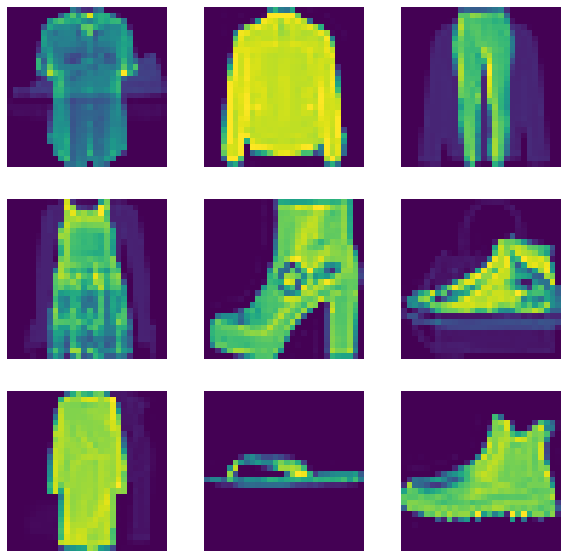

In [6]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [7]:

def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model


In [8]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [9]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 33s 35ms/step - loss: 1.1547 - accuracy: 0.6397 - val_loss: 0.6619 - val_accuracy: 0.7570
Epoch 2/10
907/907 [==============================] - 32s 35ms/step - loss: 0.9281 - accuracy: 0.7313 - val_loss: 0.5642 - val_accuracy: 0.8030
Epoch 3/10
907/907 [==============================] - 32s 35ms/step - loss: 0.8577 - accuracy: 0.7648 - val_loss: 0.4948 - val_accuracy: 0.8345
Epoch 4/10
907/907 [==============================] - 32s 35ms/step - loss: 0.8049 - accuracy: 0.7886 - val_loss: 0.4481 - val_accuracy: 0.8465
Epoch 5/10
907/907 [==============================] - 32s 35ms/step - loss: 0.7703 - accuracy: 0.7989 - val_loss: 0.4220 - val_accuracy: 0.8625
Epoch 6/10
907/907 [==============================] - 32s 36ms/step - loss: 0.7473 - accuracy: 0.8076 - val_loss: 0.4090 - val_accuracy: 0.8630
Epoch 7/10
907/907 [==============================] - 32s 36ms/step - loss: 0.7342 - accuracy: 0.8108 - val_loss: 0.3792 - val_accuracy:

In [10]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 32s 35ms/step - loss: 0.8805 - accuracy: 0.6719 - val_loss: 0.6310 - val_accuracy: 0.7685
Epoch 2/10
907/907 [==============================] - 31s 35ms/step - loss: 0.6287 - accuracy: 0.7609 - val_loss: 0.5487 - val_accuracy: 0.7940
Epoch 3/10
907/907 [==============================] - 32s 35ms/step - loss: 0.5493 - accuracy: 0.7960 - val_loss: 0.4897 - val_accuracy: 0.8235
Epoch 4/10
907/907 [==============================] - 32s 35ms/step - loss: 0.4971 - accuracy: 0.8191 - val_loss: 0.4402 - val_accuracy: 0.8490
Epoch 5/10
907/907 [==============================] - 32s 35ms/step - loss: 0.4617 - accuracy: 0.8318 - val_loss: 0.4257 - val_accuracy: 0.8525
Epoch 6/10
907/907 [==============================] - 32s 35ms/step - loss: 0.4337 - accuracy: 0.8423 - val_loss: 0.3930 - val_accuracy: 0.8600
Epoch 7/10
907/907 [==============================] - 32s 35ms/step - loss: 0.4090 - accuracy: 0.8518 - val_loss: 0.3734 - val_accuracy: